<a href="https://colab.research.google.com/github/indra622/tutorials/blob/master/Multi_AI_Agent_Study/Part3_Ch3_03_gen_report_docx_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q langchain langchain-openai langgraph python-dotenv langchain-community langchain-experimental python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Annotated, TypedDict, List, Dict, Sequence
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

# State definition
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    outline: Dict[str, str]
    current_section: int
    section_content: str
    section_image: str
    image_prompt: str
    total_sections: int
    full_report: List[Dict[str, str]]

# Graph builder initialization
graph_builder = StateGraph(State)

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=3)

In [5]:
from pydantic import BaseModel, Field, create_model

def create_outline_model(section_count: int):
    fields = {f"section{i}":
              (str, Field(description=f"Title for section {i}")) for i in range(1, section_count + 1)}
    return create_model("DynamicOutline", **fields)

In [6]:
fields = {f"section{i}":
              (str, Field(description=f"Title for section {i}")) for i in range(1, 3 + 1)}

DynamicOutline = create_model("DynamicOutline", **fields)

for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'



In [7]:
DynamicOutline = create_outline_model(5)
for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'

key:section4

value:annotation=str required=True description='Title for section 4'

key:section5

value:annotation=str required=True description='Title for section 5'



In [8]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [9]:
#from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def outline_generator(state: State):
    DynamicOutline = create_outline_model(state["total_sections"])
    outline_parser = JsonOutputParser(pydantic_object=DynamicOutline)

    outline_prompt = PromptTemplate(
        template="""
        Create an outline for a detailed report with exactly {section_count} main sections.
        {format_instructions}
        The topic is: {topic}
        """,
        input_variables=["section_count", "topic"],
        partial_variables={"format_instructions": outline_parser.get_format_instructions()},
    )

    chain = outline_prompt | llm | outline_parser

    outline = chain.invoke({
        "section_count": state["total_sections"],
        "topic": state["messages"][-1].content
    })
    return {"outline": outline}

In [11]:
from openai import OpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage

client = OpenAI()

def generate_image(prompt):
    """Generate an image using DALL-E based on the given prompt."""
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response.data[0].url

def image_generator(state: State):

    prompt_template = PromptTemplate(
        template="""
        Based on the following section content, create a prompt for generating an infographic that represents this section.

        Section content:

        {section_content}

        Image generation prompt(under 500 characters):""",
        input_variables=["section_content"],
    )

    image_prompt = llm.invoke(prompt_template.format(section_content=state["section_content"]))
    image_url = generate_image(image_prompt.content)

    current_section = {
        "title": state['outline'][f"section{state['current_section']}"],
        "content": state['section_content'],
        "image_url": image_url,
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt
    }

    updated_full_report = state.get("full_report", []) + [current_section]

    print(f"Completed section {state['current_section']} of {state['total_sections']}")

    return {
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt,
        "section_image": image_url,
        "current_section": state["current_section"] + 1,
        "full_report": updated_full_report
    }


In [12]:
def contents_writer(state: State):
    if "error" in state:
        return {"messages": [AIMessage(content=f"An error occurred: {state['error']}")]}

    if state["current_section"] > state["total_sections"]:
        return {"messages": [AIMessage(content="Report completed.")]}

    current_section_key = f"section{state['current_section']}"
    current_topic = state["outline"][current_section_key]
    search_results = search.invoke(current_topic)

    previous_sections_content = []
    for i in range(1, state['current_section']):
        section_key = f"section{i}"
        if section_key in state["section_content"]:
            previous_sections_content.append(f"""
            Section {i}:
            {state['outline'][section_key]}
            {state['section_content'][section_key]}
            """)

    previous_sections = "\n\n".join(previous_sections_content)

    section_prompt = PromptTemplate(
        template="""
        Write a detailed section for the topic: {topic}.

        Use the following search results for information: {search_results}

        Previous sections:
        {previous_sections}
        Write only the content for this section,
        do not include any image prompts or suggestions.
        Detailed statistics or information is needed,
        so you should include collected information from search result.""",
        input_variables=["topic", "search_results", "previous_sections"],
    )
    section_content = llm.invoke(section_prompt.format(
        topic=current_topic,
        search_results=search_results,
        previous_sections=previous_sections
    ))

    return {
        "section_content": section_content.content,
        "current_section": state["current_section"]
    }


In [13]:
from docx import Document
from docx.shared import Inches
import requests
from io import BytesIO

def report_generator(state: State):
    doc = Document()
    doc.add_heading(f"Report: {state['messages'][0].content}", 0)

    for section in state['full_report']:
        doc.add_heading(section['title'], level=1)
        doc.add_paragraph(section['content'])

        # 이미지 추가
        if section['image_url'] != "Image generation failed":
            try:
                response = requests.get(section['image_url'])
                image = BytesIO(response.content)
                doc.add_picture(image, width=Inches(6))
                doc.add_paragraph(f"Image prompt: {section['image_prompt']}")
            except Exception as e:
                doc.add_paragraph(f"Failed to add image: {str(e)}")

        doc.add_page_break()

    # 보고서 저장
    filename = f"report_{state['messages'][0].content}.docx".replace(" ", "_")
    doc.save(filename)

    return {
        "messages": [AIMessage(content=f"Report finalized and saved as {filename}.")],
        "report_file": filename
    }


In [14]:
# Add nodes
graph_builder.add_node("outline_generator", outline_generator)
graph_builder.add_node("contents_writer", contents_writer)
graph_builder.add_node("image_generator", image_generator)
graph_builder.add_node("report_generator", report_generator)

# Add edges
graph_builder.add_edge(START, "outline_generator")
graph_builder.add_edge("outline_generator", "contents_writer")
graph_builder.add_edge("contents_writer", "image_generator")
graph_builder.add_edge("report_generator", END)
# Add conditional edges
def should_continue_writing(state: State):
    if state["current_section"] <= state["total_sections"]:
        return "write_section"
    else:
        return "finalize_report"

graph_builder.add_conditional_edges(
    "image_generator",
    should_continue_writing,
    {
        "write_section": "contents_writer",
        "finalize_report": "report_generator"
    }
)

# Compile graph
graph = graph_builder.compile()

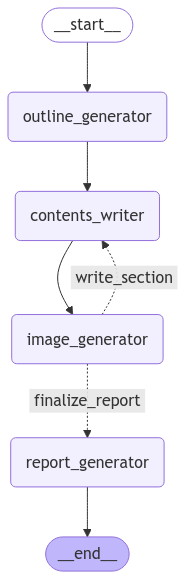

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
import os
from langchain_core.messages import HumanMessage

current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")



# 사용자 입력 받기
topic = input("보고서 주제를 입력하세요: ")
total_sections = int(input("생성할 섹션의 수를 입력하세요: "))

# 초기 상태 설정
initial_state = {
    "messages": [HumanMessage(content=topic)],
    "total_sections": total_sections,
    "current_section": 1,
}

# 그래프 실행
for chunk in graph.stream(initial_state,stream_mode="update"):
    print(chunk)

print("\n=== 보고서 생성 완료 ===")

현재 작업 디렉토리: /content
보고서 주제를 입력하세요: 한국 출산율
생성할 섹션의 수를 입력하세요: 3
Completed section 1 of 3
Completed section 2 of 3
Completed section 3 of 3

=== 보고서 생성 완료 ===
